In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving testData.csv to testData.csv


In [ ]:
df = pd.read_csv('testData.csv')
df.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,34.950001,35.590000,34.810001,35.520000,35.520000,1784400
1,2017-01-04,35.700001,35.990002,35.540001,35.950001,35.950001,508600
2,2017-01-05,36.599998,36.950001,36.380001,36.599998,36.599998,1024000
3,2017-01-06,36.599998,36.599998,36.200001,36.340000,36.340000,695700
4,2017-01-09,36.389999,37.410000,36.349998,37.259998,37.259998,2476200


In [ ]:
from collections import deque
import random
from tensorflow.python.framework import ops
%tensorflow_version 1.x

loss_lst = []
global loss_lst
name = 'Trader'

class Trader:
    def __init__(self, state_space, duration, increment, batch_size):
        self.state_space = state_space
        self.duration = duration
        self.half_window = duration // 2
        self.increment = increment
        self.action_space = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        ''' 
    Set up reinforcement learning parameters: 
    ------------------------------------------------------------------------------
    param gamma: discount rate 
    param epsilon: to determine whether we should use a random action or to use the model for the action.
    param epsilon_min: minimal value of epsilon
    param epsilon_decay: set the speed of decreasing epsilon
    '''

        self.gamma = 0.95  # Discount Factor // Value is close to 1 as we consider future rewards rather than short term rewards
        self.epsilon = 1.0 # Starting value of epsilon
        self.epsilon_min = 0.01 # Min/ End value of epsilon
        self.epsilon_decay = 0.999 # Decay value 

        ops.reset_default_graph() 
        self.sess=tf.compat.v1.InteractiveSession() 
        self.X = tf.placeholder(tf.float32, [None, self.state_space]) #(data type and shape) 
        self.Y = tf.placeholder(tf.float32, [None, self.action_space]) 
        layer1 = tf.layers.dense(self.X, 64, activation = tf.nn.leaky_relu)
        layer2 = tf.layers.dense(layer1, 32, activation = tf.nn.leaky_relu)
        layer3 = tf.layers.dense(layer2, 8, activation = tf.nn.leaky_relu) 
        self.outputs = tf.layers.dense(layer3, self.action_space) #Logits
        self.loss = tf.reduce_mean(tf.square(self.Y - self.outputs)) # Root mean squared error - Predicted and actual outputs 
        self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.loss) # Learning rate  10^-4 
        self.sess.run(tf.global_variables_initializer())

    
    def get_state(self, t, attr):
        duration = self.duration + 1
        id = t - duration + 1
        block = attr[id : t + 1] if id >= 0 else -id * [attr[0]] + attr[0 : t + 1]
        lst = []
        for i in range(duration - 1): 
            lst.append(block[i + 1] - block[i])
        return np.array([lst])
        
    def act(self, state): # Epsilon Greedy Policy 
        if random.random() <= self.epsilon:
          return random.randrange(self.action_space)
        return np.argmax(self.sess.run(self.outputs, feed_dict = {self.X: state})[0])


    def exp_replay(self, batch_size):
        mini_batch = [] 
        l = len(self.memory) 
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i]) 
        replay_size = len(mini_batch) 
        X = np.empty((replay_size, self.state_space)) 
        Y = np.empty((replay_size, self.action_space)) 
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch]) 
        Q = self.sess.run(self.outputs, feed_dict = {self.X: states}) 
        Q_new = self.sess.run(self.outputs, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            goal = Q[i] 
            goal[action] = reward 
            if not done:
                goal[action] += self.gamma * np.amax(Q_new[i]) 
            X[i] = state
            Y[i] = goal  
        loss, _ = self.sess.run([self.loss, self.optimizer], feed_dict = {self.X: X, self.Y: Y})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

 
    def trade(self, balance, attr):
        money = balance 
        selling_days = [] 
        buying_days = []
        inventory = [] 
        state = self.get_state(0, attr) 
        for t in range(0, len(attr) - 1, self.increment):
            action = self.act(state)
            next_state = self.get_state(t + 1, attr)
            
            if action == 1 and balance >= attr[t] and t < (len(attr) - self.half_window):
                inventory.append(attr[t])
                balance -= attr[t]
                buying_days.append(t)
                print('Day %d: \t Buy at: $ %f \t Balance = $ %f'% (t, attr[t], balance))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                balance += attr[t]
                selling_days.append(t) 
                try:
                    ret = ((attr[t] - bought_price) / bought_price) * 100 
                except:
                    ret = 0
                print('Day %d: \t Sell at: $ %f \t Balance = $ %f,'% (t, attr[t], balance))
            else: 
              continue
            
            state = next_state
        ret = ((balance - money) / money) * 100 
        overall = balance - money
        return buying_days, selling_days, overall, ret
        
    def train(self, iterations, checkpoint, balance, attr): # Call exp_replay, and inside exp_replay, we call epsilon_greedy 
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0, attr)
            money = balance
            for t in range(0, len(attr) - 1, self.increment):
                action = self.act(state)
                next_state = self.get_state(t + 1, attr)
                if action==0:
                  continue
                elif action == 1 and money >= attr[t] and t < (len(attr) - self.half_window):
                    inventory.append(attr[t])
                    money -= attr[t] 
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += attr[t] - bought_price
                    money += attr[t]
              
                ret = ((money - balance) / balance) # Balance = $1000, Money is the amount we have at the end  
                self.memory.append((state, action, ret, next_state, money < balance))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                loss = self.exp_replay(batch_size)  
                loss_lst.append(loss)
            if (i+1) % checkpoint == 0:
                print('Epoch: %d \t Reward: %f \t Balance: %f \t Loss: %f'%(i + 1, total_profit, money, loss))

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
close = df.Close.values.tolist()

In [ ]:
train ,test = train_test_split(close ,test_size=0.3) 

In [ ]:
len(train), len(test)

(706, 303)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

balance = 1000
duration = 30
increment = 1
batch_size = 32 

agent = Trader(state_space = duration,  duration = duration,  increment = increment,  batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
agent.train(iterations = 300, checkpoint = 50, balance = balance, attr = train) 

Epoch: 50 	 Reward: -7.269996 	 Balance: 957.710003 	 Loss: 0.495657
Epoch: 100 	 Reward: -8.150002 	 Balance: 984.499999 	 Loss: 0.309402
Epoch: 150 	 Reward: 35.510001 	 Balance: 1035.510001 	 Loss: 0.347136
Epoch: 200 	 Reward: 2.449999 	 Balance: 1002.449999 	 Loss: 0.272911
Epoch: 250 	 Reward: -64.670001 	 Balance: 935.329999 	 Loss: 0.679917
Epoch: 300 	 Reward: 47.399998 	 Balance: 1040.799998 	 Loss: 0.324701


In [ ]:
buying_days, selling_days, overall, ret = agent.trade(balance = balance, attr = test)

Day 167: 	 Buy at: $ 8.460000 	 Balance = $ 991.540000
Day 168: 	 Buy at: $ 4.560000 	 Balance = $ 986.980000
Day 169: 	 Sell at: $ 29.680000 	 Balance = $ 1016.660000,
Day 205: 	 Sell at: $ 5.850000 	 Balance = $ 1022.510000,


In [ ]:
if overall>0:
  print("Profit = $ %.3f " % overall)
else:
  print("Loss = $ %.3f " % overall)

Profit = $ 22.510 


In [ ]:
print('Return = %.3f' %ret, "%")

Return = 2.251 %


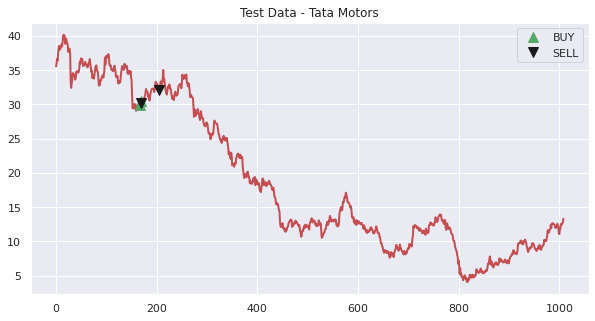

In [ ]:
fig = plt.figure(figsize = (10,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='g', label = 'BUY', markevery = buying_days)
plt.plot(close, 'v', markersize=10, color='k', label = 'SELL', markevery = selling_days)
plt.title('Test Data - Tata Motors')
plt.legend()
plt.show()  

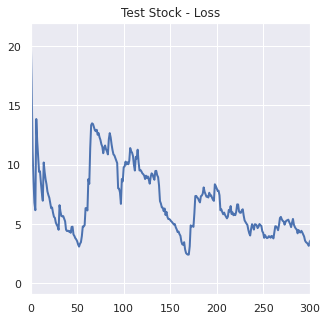

In [ ]:
fig = plt.figure(figsize = (5,5))
plt.plot(loss_lst, color='b', lw=2.)
plt.xlim([0,300])
plt.title('Test Stock - Loss')
plt.show()